# Titanic: Machine Learning from Disaster

In [1]:
# https://www.kaggle.com/c/titanic

In [2]:
import sklearn
import pandas as pd

In [3]:
# Загружаем данные из файлов
train = pd.read_csv('./homework/train.csv')
test = pd.read_csv('./homework/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

In [5]:
# Заполняем пропуски в данных медианными 
# значениями факторов на обучающей выборке
train_median = train.median()
train_imp = train.fillna(train_median)
test_imp = test.fillna(train_median)

In [6]:
# Бинаризуем категориальные признаки
CATEGORY_COL = ['Sex', 'Pclass', 'Embarked']
train_dummies = pd.get_dummies(train_imp, columns=CATEGORY_COL, drop_first=True)
test_dummies = pd.get_dummies(test_imp, columns=CATEGORY_COL, drop_first=True)

In [7]:
train_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1,0,1


In [11]:
# Удаляем лишние столбцы
DROP_COL = ['PassengerId', 'Name', 'Ticket', 'Cabin']
TARGET_COL = 'Survived'
X_train = train_dummies.drop(DROP_COL + [TARGET_COL], axis=1)
y_train = train_dummies[TARGET_COL]
X_test = test_dummies.drop(DROP_COL, axis=1)

## Подбор параметров моделей с помощью GridSearch

In [12]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer




# grid_RFC = GridSearchCV(RandomForestClassifier(warm_start=True, random_state=12345), param_grid, cv=kf, scoring=sc)
# grid_RFC.fit(X_train, y_train)
# grid_RFC.best_estimator_

## Предварительная оценка поведения RandomForest на данных

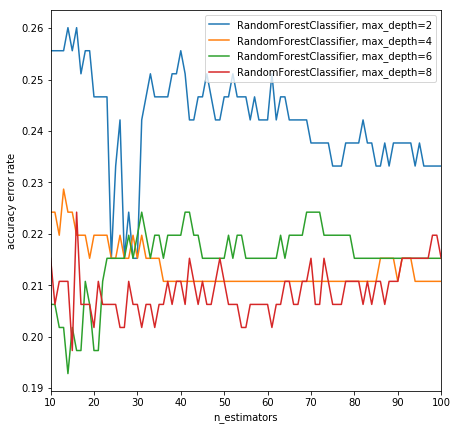

In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from collections import OrderedDict

RANDOM_STATE = 12345
MIN_ESTIMATORS = 10
MAX_ESTIMATORS = 100

% matplotlib inline

ensemble_clfs = [
    ("RandomForestClassifier, max_depth=2",
        RandomForestClassifier(warm_start=True, max_depth=2,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_depth=4",
        RandomForestClassifier(warm_start=True, max_depth=4,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_depth=6",
        RandomForestClassifier(warm_start=True, max_depth=6,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_depth=8",
        RandomForestClassifier(warm_start=True, max_depth=8,
                               max_features="sqrt",
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, 
                                                        y_train,
                                                        test_size=0.25, 
                                                        random_state=RANDOM_STATE
                                                       )                                                       
for label, model in ensemble_clfs:
    for i in range(MIN_ESTIMATORS, MAX_ESTIMATORS + 1):
        model.set_params(n_estimators=i)
        model.fit(X_train_, y_train_)
        y_pred_ = model.predict(X_test_)
        acc_error = 1 - accuracy_score(y_test_, y_pred_)
        error_rate[label].append((i, acc_error))

plt.figure(figsize=(7,7))
        
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(MIN_ESTIMATORS, MAX_ESTIMATORS)
plt.xlabel("n_estimators")
plt.ylabel("accuracy error rate")
plt.legend(loc="upper right")
plt.show()

из графика видно, что наиболее перспективной кажется модель с глубиной дерева 6, число деревьев - от 10 до 20. Прогоним еще раз через GridSearch

In [29]:
kf = KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
sc = make_scorer(accuracy_score)
param_grid = { 'n_estimators': list(range(10, 50)),'max_features': ['sqrt', 'log2', None] }
estimator = RandomForestClassifier( max_depth=6, random_state=RANDOM_STATE )

gs_RFC = GridSearchCV(estimator, param_grid, scoring=sc, cv=kf)
gs_RFC.fit(X_train, y_train)
best_RFC = gs_RFC.best_estimator_

In [30]:
best_RFC

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=13, n_jobs=1, oob_score=False, random_state=12345,
            verbose=0, warm_start=False)

оценим качество классификатора на тестовой выборке:

In [35]:
_, X_test__, _, y_test__ = train_test_split(X_train, 
                                            y_train,
                                            test_size=0.25)

y_pred = best_RFC.predict(X_test__)
print(accuracy_score(y_test__, y_pred))

0.874439461883


попробуем закоммититься на Kaggle

In [36]:
predicted = best_RFC.predict(X_test)
with open('submission_RFC.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))

Kaggle score = 0.78469
Keep trying...

## Проделываем то же самое для GradientBoosting

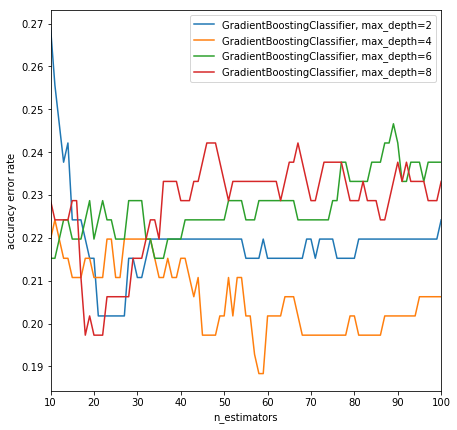

In [54]:
ensemble_clfs = [
    ("GradientBoostingClassifier, max_depth=2",
        GradientBoostingClassifier(warm_start=True, max_depth=2,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("GradientBoostingClassifier, max_depth=4",
        GradientBoostingClassifier(warm_start=True, max_depth=4,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("GradientBoostingClassifier, max_depth=6",
        GradientBoostingClassifier(warm_start=True, max_depth=6,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
   ("GradientBoostingClassifier, max_depth=8",
        GradientBoostingClassifier(warm_start=True, max_depth=8,
                               max_features="sqrt",
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, 
                                                        y_train,
                                                        test_size=0.25, 
                                                        random_state=RANDOM_STATE
                                                       )
X_train_ = X_train_.as_matrix().copy()
y_train_ = y_train_.as_matrix().copy()


for label, model_ in ensemble_clfs:
    for i in range(MIN_ESTIMATORS, MAX_ESTIMATORS + 1):
        model_.set_params(n_estimators=i)
        model_.fit(X_train_, y_train_)
        y_pred_ = model_.predict(X_test_)
        acc_error = 1 - accuracy_score(y_test_, y_pred_)
        error_rate[label].append((i, acc_error))

plt.figure(figsize=(7,7))
        
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(MIN_ESTIMATORS, MAX_ESTIMATORS)
plt.xlabel("n_estimators")
plt.ylabel("accuracy error rate")
plt.legend(loc="upper right")
plt.show()

In [59]:
param_grid = {
    'n_estimators': list(range(40, 80)),
    'max_features': ['sqrt', 'log2', None],
    'learning_rate': list(np.append(np.linspace(0.001, 0.01, 10),np.linspace(0.02, 0.1, 9))) }
estimator = GradientBoostingClassifier( max_depth=4, random_state=RANDOM_STATE )

gs_GBC = GridSearchCV(estimator, param_grid, scoring=sc, cv=kf)
gs_GBC.fit(X_train, y_train)
best_GBC = gs_GBC.best_estimator_

In [60]:
best_GBC

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.059999999999999998, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=12345,
              subsample=1.0, verbose=0, warm_start=False)

## Предсказание моделей для стеккинга

In [69]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

def cross_val_predict_proba(estimator, X_train, y_train):
    kfold = KFold(n_splits=4, shuffle=True, random_state=12345)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba')

# TODO: подобрать гиперпараметры для ансамблей

# инициализирем модели с подобранными гиперпараметрами
rf_estimator = RandomForestClassifier()
gb_estimator = GradientBoostingClassifier()

# получаем предсказания вероятностей ансамблей на кросс-валидации для обучающей выборки
rf_train_pred = cross_val_predict_proba(rf_estimator, X_train, y_train)
gb_train_pred = cross_val_predict_proba(gb_estimator, X_train, y_train)

X_train_stack = np.stack([rf_train_pred[:,1], gb_train_pred[:,1]], axis=1)

# получаем предсказания ансамблей для тестовой выборки
rf_test_pred = rf_estimator.fit(X_train, y_train).predict_proba(X_test)
gb_test_pred = gb_estimator.fit(X_train, y_train).predict_proba(X_test)

X_test_stack = np.stack([rf_test_pred[:,1], gb_test_pred[:,1]], axis=1)

## Объединяем предсказания ансамблей с помощью логистической регрессии

In [70]:
from sklearn.linear_model import LogisticRegression

# TODO: подобрать гиперпараметры LogisticRegression

logreg = LogisticRegression().fit(X_train_stack, y_train)
predicted = logreg.predict(X_test_stack)

## Формируем файл для отправки

In [71]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))